In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
    sys.path.append("../")
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [13]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    
    return lambda x: np.ones(nA) / nA

In [15]:
def create_greedy_policy(Q, nA):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        nA: Number of actions in the environment
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    A = np.zeros(nA)
    def policy_fn(observation):
        A[np.argmax(Q[observation])] = 1.0
        return A
    return policy_fn

In [21]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    returns_count = defaultdict(lambda: np.zeros(nA))

    for ie in range(num_episodes):
        if (ie+1) % 1000 == 0:
            print("\rEpisode {}/{}.".format(ie+1, num_episodes), end="")
            sys.stdout.flush()
        # Our greedily policy we want to learn
        target_policy = create_greedy_policy(Q, nA)
        observation = env.reset()
        done = False
        ep = []
        G = 0
        W = 1
        while True:
            prob_be = behavior_policy(observation)
            action = np.random.choice(range(nA), 1, p=prob_be)[0]
            next_observation, reward, done, _ = env.step(action)
            ep.append((observation, action, reward))
            if done:
                break
            observation = next_observation
        for e in ep[::-1]:
            ob, ac, re = e
            G = G*discount_factor + re
            returns_count[ob][ac] += W
            prev_q = Q[ob][ac]
            Q[ob][ac] += (G - prev_q)*W / returns_count[ob][ac]
            prob_be = behavior_policy(ob)
            prob_ta = target_policy(ob)
            W *= (prob_ta[ac] / prob_be[ac])
            if W == 0:
                break
        
    return Q, target_policy

In [22]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Episode 500000/500000.

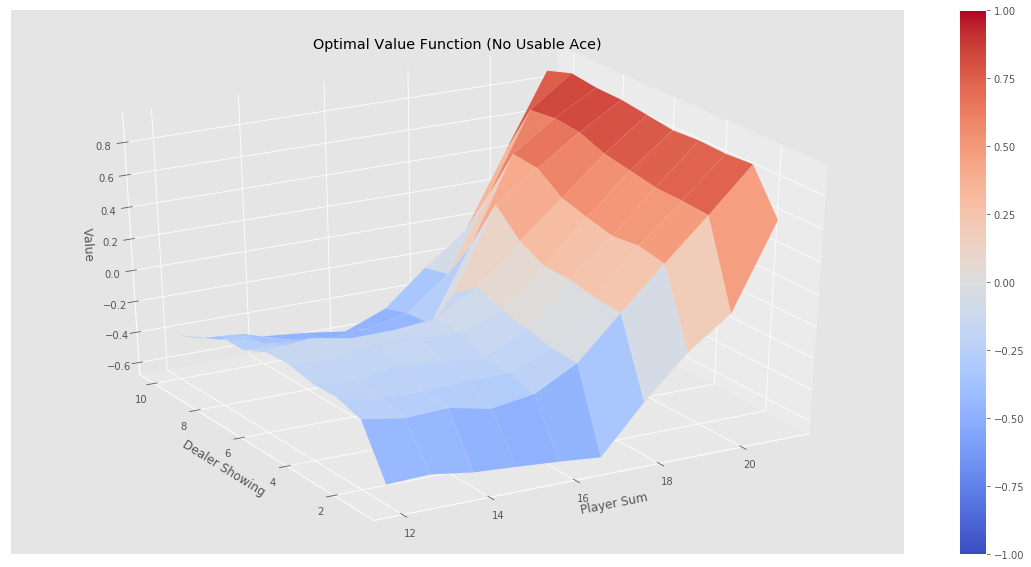

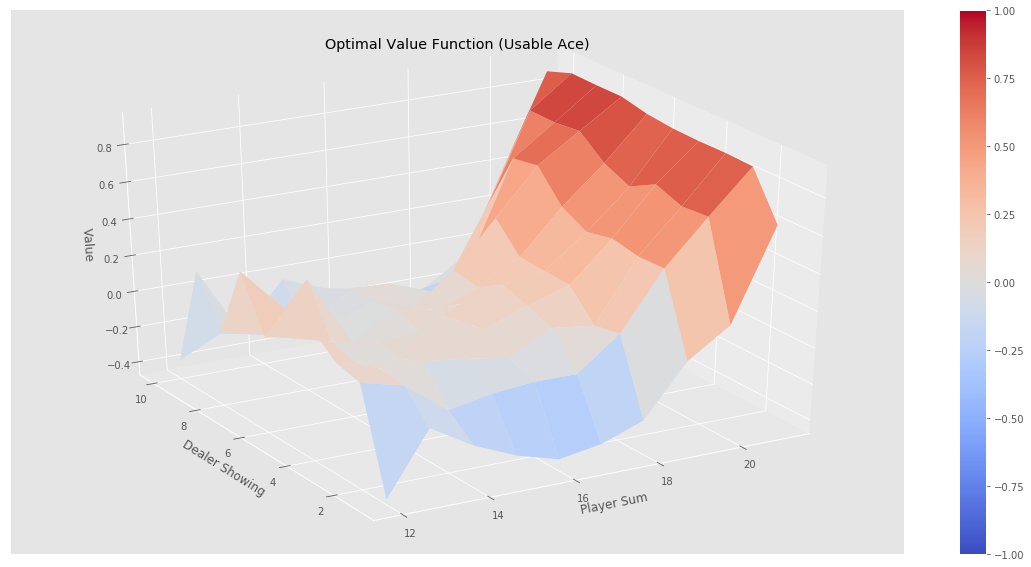

In [25]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

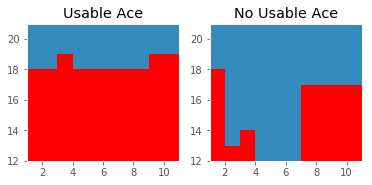

In [26]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

fig1 = plt.figure()
ax1 = fig1.add_subplot(121, aspect='equal', ylim=[12,21], xlim=[1,11], title="Usable Ace")
ax2 = fig1.add_subplot(122, aspect='equal', ylim=[12,21], xlim=[1,11], title="No Usable Ace")

for state, action_arr in Q.items():
    score, dealer, ace = state
    action = np.argmax(action_arr)
    facecolor = "red" if action == 1 else None
    if ace:
        ax1.add_patch(patches.Rectangle((float(dealer), float(score)), 1.0, 1.0, facecolor=facecolor))
    else:
        ax2.add_patch(patches.Rectangle((float(dealer), float(score)), 1.0, 1.0, facecolor=facecolor))